In [46]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
%matplotlib notebook

In [1242]:
def plot_line(n, r):
    t = np.array([n[1], -n[0]])
    p = r * n
    p0 = p + 10 * t
    p1 = p - 10 * t
    plt.plot([p[0],p[0]], [p0[1], p1[1]], color = 'black', linestyle = '--')

<IPython.core.display.Javascript object>


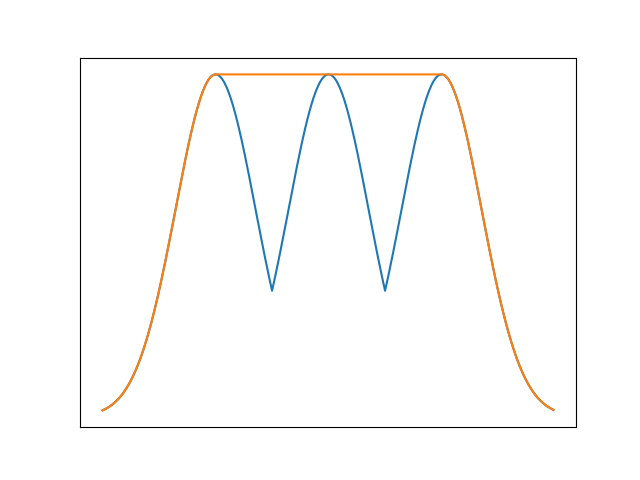

<IPython.core.display.Javascript object>


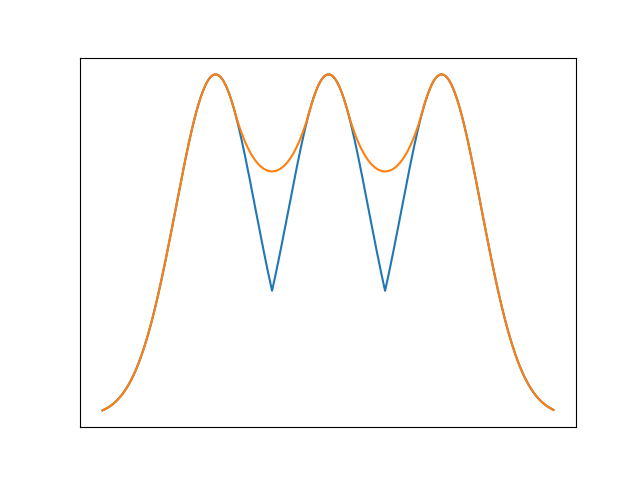

<IPython.core.display.Javascript object>


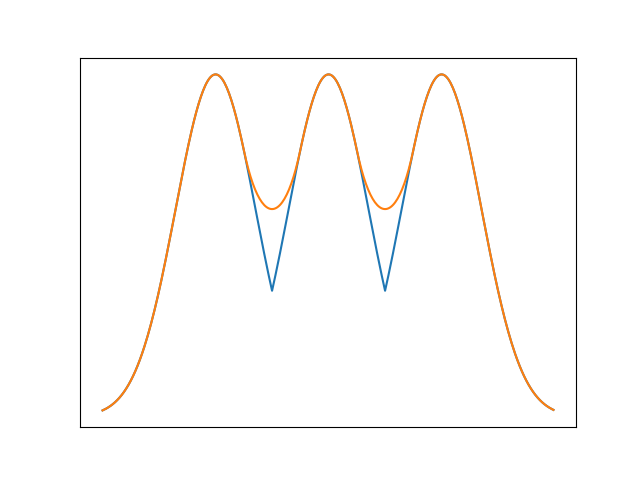

<IPython.core.display.Javascript object>


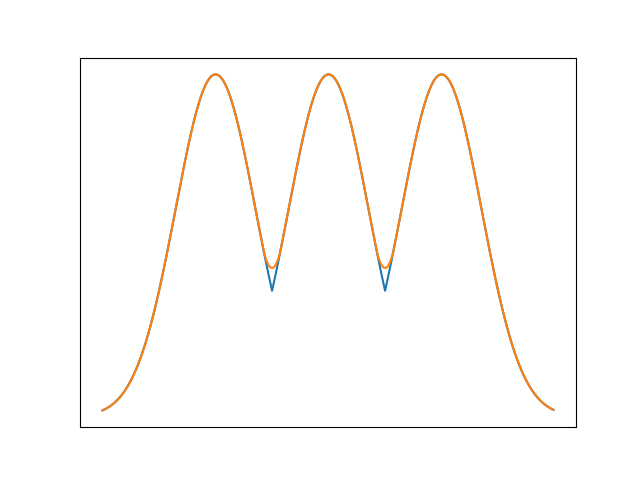

<IPython.core.display.Javascript object>


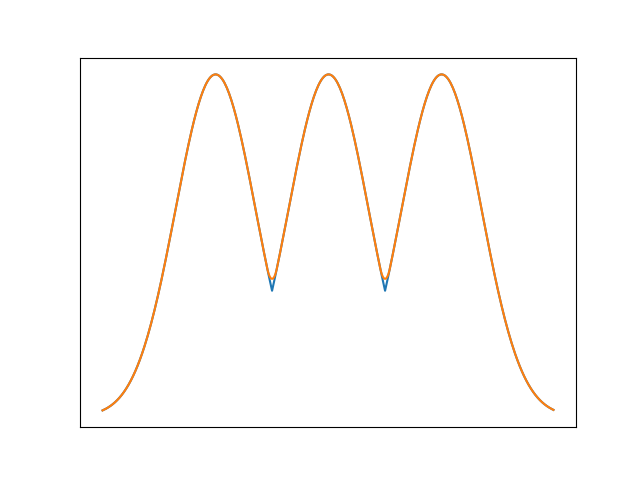

0.0791999999999598
-15.839999999996117


In [1243]:
h = 0.01
x = np.arange(0, 4, h)

mu = np.array((1, 2, 3))
b = np.array((0,0,0))
xx = np.column_stack([x for _ in mu])

s = 0.5
v = np.max(-((xx - mu)/s)**2 + b, axis = 1)

def cons_d4(x):
    return (x[4:] - 4 * x[3:-1] + 6 * x[2:-2] - 4 * x[1:-3] + x[:-4]) / (h **4)
    
def cons_d2(x):
    return (x[2:] - 2 * x[1:-1] + x[:-2]) / (h **2)

def cons_d3(x):
    return ((-0.5 * x[4:] + 1 * x[3:-1] - 1 * x[1:-3] + 0.5*x[:-4]) / (h **3))**2

def cost(x):
    return np.linalg.norm((x - v), ord = 2)

for max_ddf in [0, 1, 2, 10, 20]:
    plt.figure()
    max_ddf = max_ddf/s**2

    l_constraint = LinearConstraint(np.eye(len(v)), v, np.inf)
    constraint_d2f = NonlinearConstraint(cons_d2, -np.inf, max_ddf)
    res = minimize(cost, v.copy(), method = 'SLSQP', constraints=[l_constraint, constraint_d2f])
    plt.plot(x, np.exp(v))
    f = res['x']
    f = np.exp(f)
    plt.plot(x, f)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
#plt.plot(x, x)
df = (f[2:] - f[:-2]) / (2 * h)
#plt.plot(x[1:-1], x[1:-1] + s**2 * df / 2)
#plt.plot(x[1:-1], (res['x'][2:] - res['x'][:-2]) / (2*h))
#plt.plot(x[1:-1], (res['x'][2:] - 2 * res['x'][1:-1] + res['x'][:-2]) / (h**2))
print(np.sum((res['x'][2:] - res['x'][:-2]) / (2*h)) * h)
print(np.sum((res['x'][2:] - 2 * res['x'][1:-1] + res['x'][:-2]) / (h**2)) * h)
#print(res)

In [1443]:
from scipy.optimize import LinearConstraint, minimize, NonlinearConstraint
import scipy
import itertools
def value(t, direction, Ns, Rs, b = 2):
    a = 2
    d = direction.copy()
    coeffs = []
    times = []
    Rs = Rs.copy() * b
    sign = np.concatenate((np.ones_like(Rs), -np.ones_like(Rs)), axis = 0)
    Rs = np.concatenate((Rs,Rs), axis = 0)
    Ns = np.concatenate((Ns,-Ns), axis = 0)

    vel = direction * a
    in_collision = []
    constraint_signs = []
    print(direction)
    while t > 0:
        coeffs.append(vel)
        progress = Ns @ vel + b * (Ns @ direction) * sign
        progress_mask = progress > 1e-14
        collision_times = Rs[progress_mask] / progress[progress_mask]
        mask = collision_times > 0
        if not np.any(mask):
            times.append(t)
            break
        
        i = np.argmin(collision_times[mask])
        time_step = collision_times[mask][i]
        if time_step > t:
            times.append(t)
            break
        in_collision.append(Ns[progress_mask][mask][i])
        constraint_signs.append(sign[progress_mask][mask][i])
        times.append(time_step)
        
        t -= time_step
        Rs -= time_step * progress
        
        constraints = np.array(in_collision)
        for i in range(len(in_collision)):
            for combo_i in itertools.combinations(range(len(in_collision)), i+1):
                combo = np.array(in_collision)[list(combo_i)]
                combo_signs = np.array(constraint_signs)[list(combo_i)]
                A = np.array(combo)
                #print(A)
                #print(-b * combo @ direction * combo_signs)
                res = minimize(lambda x: np.linalg.norm(x - a * direction)**2, 
                              a * direction,
                              method = 'SLSQP',
                              jac = lambda x: 2 * (x - a * direction),
                              constraints = [LinearConstraint(A, 
                                                              -np.inf, 
                                                              -b * combo @ direction * combo_signs)])
                v = res['x']
                
                #A_null = scipy.linalg.null_space(A.T, rcond = None)
                #L = np.diag([-b] * len(A.T) + [a] * len(A_null.T))
                #V = np.concatenate((A, A_null), axis = 1).T
                #hess = V.T @ L @ V
                #v = hess @ direction
                if np.all(constraints @ v <= (-b * constraints @ direction + 1e-1)):
                    in_collision = list(combo)
                    constraint_signs = list(combo_signs)
                    vel = v
                    break
        constraints = np.array(in_collision)
        print(constraints)
        #print(constraint_signs)
        print(constraints @ vel)
        print(-b * constraints @ direction * np.array(constraint_signs))
        #print(constraints @ v <= (-b * constraints @ direction * combo_signs + 1e-8))
                
    coeffs = np.array(coeffs)
    times = np.array(times)
    #print('t',times)
    #print(coeffs)
    
    last_gd = np.sum(times * coeffs.T, axis = 1)
    gradients = np.cumsum(times * (coeffs @ direction))
    #print((coeffs @ direction))
    gd = 0
    val = 0
    for v,t in zip(gradients, times):
        val += gd*t + (v * t - gd * t) / 2
        gd = v
    return val, last_gd

def v(xy, mu, s):
    i = np.argmin(np.linalg.norm(xy - mu, axis = 1))
    p = xy - mu[i]
    distance = np.linalg.norm(p)
    p /= distance

    n = mu - mu[i]
    d = np.linalg.norm(n, axis = 1) / 2
    d[d < 1e-8] = np.inf
    n = (n.T / (2 * d)).T

    val, last_gd = value(distance, p, n, d, 2)
    Rs = 2 * (d - n @ (xy - mu[i]))
    gd = 2 * (xy - mu[i])
    res = minimize(lambda x: np.linalg.norm(x - gd) ** 2, gd.copy(),
                   jac = lambda x: 2 * (x - gd),
                   method = 'SLSQP',
                  constraints = [LinearConstraint(n, -Rs, Rs)])
    print('res',res['x'])
    print('last_gd', last_gd)
    print('diff', np.linalg.norm(res['x'] - last_gd))
    print('diff_dir', (res['x'] - last_gd)/np.linalg.norm(res['x'] - last_gd))
    
    return -val

def val_gd(x, pois, s):
    f = v(x, pois, s)
    gd = np.zeros_like(x)
    h = 1e-10
    for i in range(len(gd)):
        x_h = x.copy()
        x_h[i] += h
        gd[i] = (v(x_h, pois, s) - f) / h
    return f, gd

def slow_val(x, pois, s):
    
    i = np.argmin(np.linalg.norm(x - mu, axis = 1))
    p = x - mu[i]
    distance = np.linalg.norm(p)
    p /= distance

    n = mu - mu[i]
    d = np.linalg.norm(n, axis = 1) / 2
    d[d < 1e-8] = np.inf
    n = (n.T / (2 * d)).T
    
    val = 0
    h = 0.005
    for t in np.arange(0, distance, h):
        xy = mu[i] + p * t
    
        Rs = 2 * (d - n @ (xy - mu[i]))
        gd = 2 * (xy - mu[i])
        res = minimize(lambda x: np.linalg.norm(x - gd) ** 2, gd.copy(),
                       jac = lambda x: 2 * (x - gd),
                       method = 'SLSQP',
                      constraints = [LinearConstraint(n, -Rs, Rs)])
        val += res['x'] @ p * h
    return -val


def hess_vals(x, pois):
    a = 2
    i = np.argmin(np.linalg.norm(x - mu, axis = 1))
    p = x - mu[i]
    distance = np.linalg.norm(p)
    p /= distance

    n = mu - mu[i]
    d = np.linalg.norm(n, axis = 1) / 2
    d[d < 1e-8] = np.inf
    n = (n.T / (2 * d)).T
    
    def hess_loss(x):
        x = x.reshape((2,2))
        return np.linalg.norm(x - a * np.eye(2))
    
    def hess_constr(x,ns):
        x = x.reshape((2,2))
        if len(ns) == 0:
            return 0
        return (x @ ns.T).flatten()
    
    val = 0
    h = 0.001
    grad = np.zeros_like(p)
    for t in np.arange(0, distance, h):
        xy = mu[i] + p * t
    
        Rs = 2 * (d - n @ (xy - mu[i]))
        gd = 2 * (xy - mu[i])
        mask = n @ gd > Rs
        ns = n[mask]
        constraints = []
        if len(ns) > 0:
            constraints.append(NonlinearConstraint(lambda x: hess_constr(x,ns), -3, -3))
        res = minimize(hess_loss, (a * np.eye(2)).flatten(),
                       method = 'SLSQP',
                    constraints = constraints)
        print(res['success'],t,res['x'])
        grad += res['x'].reshape((2,2)) @ p * h
    print(Rs)
    print(n)
    print(grad)


In [1444]:

h = 0.01
s = 1
n = np.arange(20)
mu_y = 1. * np.zeros_like(n)
mu_y[n % 2 == 0] += 0.2
mu_y[n % 2 != 0] -= 0.2

mu_x = 0.05*n - 0.5
mu = np.column_stack((mu_x, mu_y)) - 0.25
mu = np.concatenate((mu, np.column_stack((mu_x, mu_y)) + 0.25), axis = 0)

relevant_index = np.array((4, 20, 2, 6,))
mu = mu[relevant_index,:]

start = np.array((-0.75, -0.05))
end = np.array((-0.25, 0.45))
_t = 0.5-h
xy = (end - start) * _t + start
print(hess_vals(xy,mu))
#print('-------')
#_t += 2*h
#xy = (end - start) * _t + start
#print(v(xy,mu,s))

#plt.scatter(*mu.T)
#plt.scatter(*mu[0].T, color = 'black')
#plt.scatter(*xy.T, color = 'green')

True 0.0 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.001 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.002 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.003 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.004 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.005 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.006 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.007 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.008 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.009000000000000001 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.01 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.011 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.012 [2.00000043e+00 5.14650052e-07 5.14650052e-07 2.00000043e+00]
True 0.013000000000000001 [2.00000043e+

True 0.185 [-3.         -1.69857094 -3.         -1.69857102]
True 0.186 [-3.         -1.69857094 -3.         -1.69857102]
True 0.187 [-3.         -1.69857094 -3.         -1.69857102]
True 0.188 [-3.         -1.69857094 -3.         -1.69857102]
True 0.189 [-3.         -1.69857094 -3.         -1.69857102]
True 0.19 [-3.         -1.69857094 -3.         -1.69857102]
True 0.191 [-3.         -1.69857094 -3.         -1.69857102]
True 0.192 [-3.         -1.69857094 -3.         -1.69857102]
True 0.193 [-3.         -1.69857094 -3.         -1.69857102]
True 0.194 [-3.         -1.69857094 -3.         -1.69857102]
True 0.195 [-3.         -1.69857094 -3.         -1.69857102]
True 0.196 [-3.         -1.69857094 -3.         -1.69857102]
True 0.197 [-3.         -1.69857094 -3.         -1.69857102]
True 0.198 [-3.         -1.69857094 -3.         -1.69857102]
True 0.199 [-3.         -1.69857094 -3.         -1.69857102]
True 0.2 [-3.         -1.69857094 -3.         -1.69857102]
True 0.201 [-3.         -1.

<IPython.core.display.Javascript object>


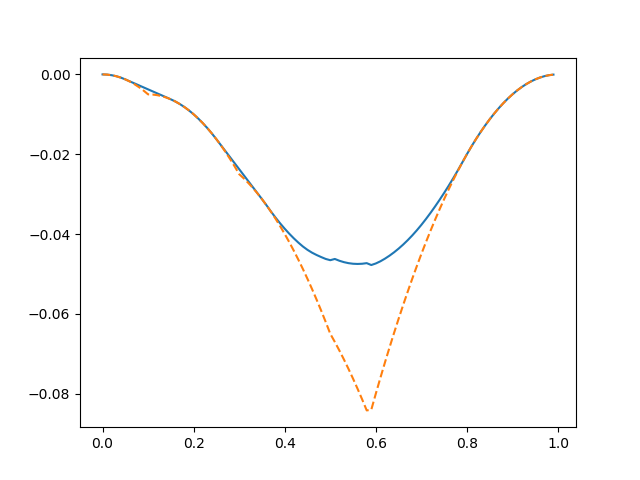

t [1.38777878e-17]
[[ 0. -2.]]
[2.77555756e-17]
res [ 0.00000000e+00 -2.77555756e-17]
last_gd [ 0.00000000e+00 -2.77555756e-17]
diff 0.0
diff_dir [nan nan]
t [0.00707107]
[[1.41421356 1.41421356]]
[0.01414214]
res [0.01 0.01]
last_gd [0.01 0.01]
diff 0.0
diff_dir [nan nan]
t [0.01414214]
[[1.41421356 1.41421356]]
[0.02828427]
res [0.02 0.02]
last_gd [0.02 0.02]
diff 0.0
diff_dir [nan nan]
t [0.0212132]
[[1.41421356 1.41421356]]
[0.04242641]
res [0.03 0.03]
last_gd [0.03 0.03]
diff 0.0
diff_dir [nan nan]
t [0.02828427]
[[1.41421356 1.41421356]]
[0.05656854]
res [0.04 0.04]
last_gd [0.04 0.04]
diff 0.0
diff_dir [nan nan]
t [3.53553391e-02 4.16333634e-17]
[[ 1.41421356  1.41421356]
 [-1.41421356  1.41421356]]
[0.07071068 0.07071068]
res [0.05 0.05]
last_gd [0.05 0.05]
diff 1.1816510524180758e-16
diff_dir [0.99827437 0.05872202]
t [0.03535534 0.00707107]
[[ 1.41421356  1.41421356]
 [-1.41421356  1.41421356]]
[0.07071068 0.07071068]
res [0.04 0.06]
last_gd [0.04 0.06]
diff 1.387778780781445

C:\Users\kevin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


 [0.15206906 0.00506897 0.05048488 0.03568759]
[[ 0.32879797  1.97278785]
 [-0.32879797  1.97278785]
 [-1.5859667  -1.21848661]
 [ 0.32879797 -2.36734542]]
[0.30413813 0.31372807 0.23988691 0.15848062]
res [-0.02   0.164]
last_gd [-0.02   0.164]
diff 1.5612511283791264e-15
diff_dir [0.28 0.96]
t [0.13838799 0.01920486 0.04469367 0.04681185]
[[ 0.36130304  1.96709433]
 [-0.36130304  1.96709433]
 [-1.56564651 -1.24448825]
 [ 0.36130304 -2.40065798]]
[0.27677597 0.3126787  0.24533207 0.13785718]
res [-0.01   0.142]
last_gd [-0.01   0.142]
diff 7.609091204154493e-16
diff_dir [0.17326509 0.98487523]
t [0.12747549 0.03059412 0.03921389 0.05766748]
[[ 0.39223227  1.96116135]
 [-0.39223227  1.96116135]
 [-1.54585659 -1.26898676]
 [ 0.39223227 -2.43184008]]
[0.25495098 0.31143242 0.25074849 0.11766968]
res [0.   0.12]
last_gd [-4.82253126e-16  1.20000000e-01]
diff 8.450151264585269e-16
diff_dir [0.57070354 0.82115618]
t [0.14385564 0.01353935 0.10154516]
[[-0.34757067  1.96956712]
 [ 0.34757067

res [-0.20758621 -0.18896552]
last_gd [-0.20758621 -0.18896552]
diff 3.925231146709438e-17
diff_dir [0.70710678 0.70710678]
t [0.14647212 0.00202031]
[[-1.41421356 -1.41421356]
 [-0.04876598  1.99940538]]
[0.29294424 0.29015761]
res [-0.20724138 -0.20310345]
last_gd [-0.20724138 -0.20310345]
diff 6.206335383118183e-17
diff_dir [-0.89442719 -0.4472136 ]
t [0.14142136]
[[-1.41421356 -1.41421356]]
[0.28284271]
res [-0.2 -0.2]
last_gd [-0.2 -0.2]
diff 3.925231146709438e-17
diff_dir [-0.70710678 -0.70710678]
t [0.13435029]
[[-1.41421356 -1.41421356]]
[0.26870058]
res [-0.19 -0.19]
last_gd [-0.19 -0.19]
diff 0.0
diff_dir [nan nan]
t [0.12727922]
[[-1.41421356 -1.41421356]]
[0.25455844]
res [-0.18 -0.18]
last_gd [-0.18 -0.18]
diff 0.0
diff_dir [nan nan]
t [0.12020815]
[[-1.41421356 -1.41421356]]
[0.24041631]
res [-0.17 -0.17]
last_gd [-0.17 -0.17]
diff 0.0
diff_dir [nan nan]
t [0.11313708]
[[-1.41421356 -1.41421356]]
[0.22627417]
res [-0.16 -0.16]
last_gd [-0.16 -0.16]
diff 0.0
diff_dir [nan 

In [1338]:
h=0.01
t = np.arange(0, 1, h)

x = (end[0] - start[0]) * t + start[0]
y = (end[1] - start[1]) * t + start[1]
XY = np.column_stack((x, y))

XYMU = np.stack([XY for _ in mu], axis= 2)

disc_f = np.max(-np.linalg.norm(XYMU-mu.T, axis = 1)**2 / s**2, axis = 1)
plt.figure()
f = []
for xy, _t in zip(XY, t):
    val = v(xy, mu, s)
    #val,gd = val_gd(xy,mu,s)
    f.append(val)
f = np.array(f)
plt.plot(t,f)
plt.plot(t,disc_f, linestyle = '--')
plt.show()

<IPython.core.display.Javascript object>


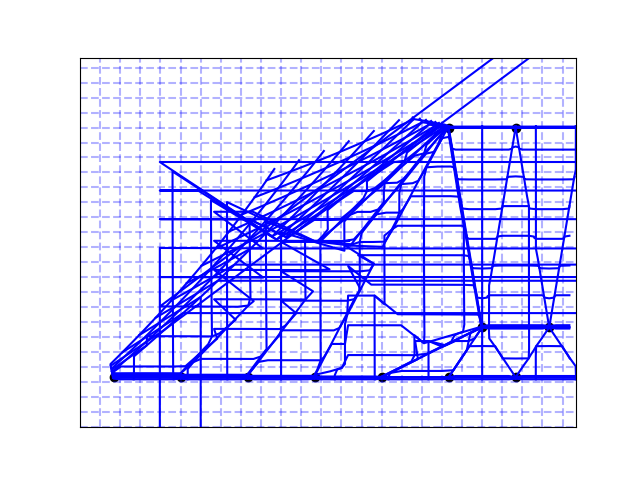

<IPython.core.display.Javascript object>


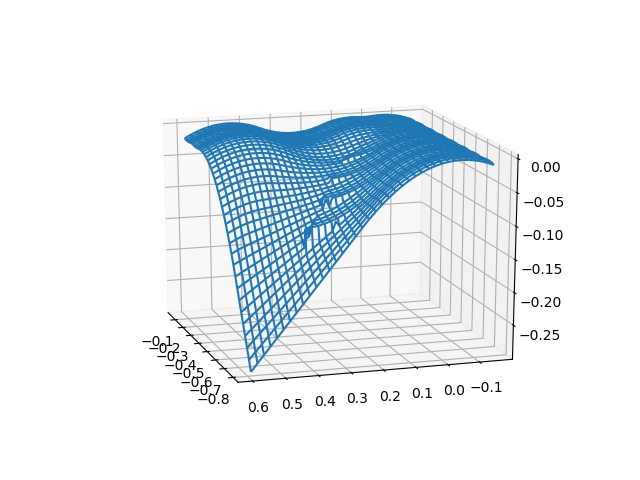

In [91]:
import time


def value(xy, mu):

    i = np.argmin(np.linalg.norm(xy - mu, axis = 1))
    root = mu[i]
    mu = mu[np.arange(len(mu)) != i]
    
    Ns = mu - root
    Rs = np.linalg.norm(Ns, axis = 1)
    Ns = (Ns.T / Rs).T
    
    res = minimize(lambda x: np.linalg.norm(x - (xy - root))**2, np.zeros_like(xy), method = 'SLSQP',
                    jac = lambda x: 2 * (x - (xy - root)),
                    constraints = [LinearConstraint(Ns, -np.inf, Rs/4)])
    p = res['x'] + root
    return -np.linalg.norm(xy - root)**2 + 2 * np.linalg.norm(xy-p)**2
    
def val_gd(xy, mu):
    v_0 = value(xy, mu)
    
    gd = np.zeros_like(xy)
    h = 1e-8
    for i in range(len(xy)):
        xy_h = xy.copy()
        xy_h[i] += h
        gd[i] = (value(xy_h,mu) - v_0) / (h)
    return v_0, gd


h = 0.01
s = 1
x = np.arange(-1,-0.25,h) + 0.2
y = np.arange(0.25,1,h) - 0.4
X, Y = np.meshgrid(x, y)
XY = np.column_stack((X.flatten(), Y.flatten()))

theta = np.linspace(0, 2 * np.pi, 200)
#mu = np.array(((-0.4, 0), (0.4, 0)))
mu = 0.5 * np.array((np.cos(theta), np.sin(theta))).T
mu = np.array((np.arange(-0.5, 0.5, 0.01), np.zeros_like(np.arange(-0.5, 0.5, 0.01)))).T

n = np.arange(20)
mu_y = 1. * np.zeros_like(n)
mu_y[n % 2 == 0] += 0.2
mu_y[n % 2 != 0] -= 0.2

mu_x = 0.05*n - 0.5
mu = np.column_stack((mu_x, mu_y)) - 0.25
mu = np.concatenate((mu, np.column_stack((mu_x, mu_y)) + 0.25), axis = 0)

df = []
f = []
for xy in XY:
    val, gd = val_gd(xy,mu)
    f.append(val)
    df.append(gd * np.exp(val))
df = np.array(df)

XY_prime = XY + s**2 * df / 2
XY_prime = XY_prime.reshape((*X.shape, 2))
XY = XY.reshape(*X.shape,2)

plt.figure()
for i in range(0, len(XY_prime), len(XY_prime) // 20):
    plt.plot(XY_prime[i,:,0], XY_prime[i,:,1], color = 'blue')
for i in range(0, len(XY_prime), len(XY_prime) // 20):
    plt.plot(XY_prime[:,i,0], XY_prime[:,i,1], color = 'blue')
for i in range(0, len(XY_prime), len(XY_prime) // 20):
    plt.plot(XY[i,:,0], XY[i,:,1], color = 'blue', linestyle = '--', alpha = 0.3)
for i in range(0, len(XY_prime), len(XY_prime) // 20):
    plt.plot(XY[:,i,0], XY[:,i,1], color = 'blue', linestyle = '--', alpha = 0.3)
plt.scatter(*mu.T, color = 'black')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim([min(x), max(x)])
plt.ylim([min(y), max(y)])
plt.figure()
ax = plt.gca(projection = '3d')
ax.plot_wireframe(X, Y, np.array(f).reshape(X.shape))
plt.show()

In [6]:
from scipy.interpolate import griddata

In [166]:
k = 0.0035
t = np.arange(0, 1, k)
x = (t - 0.5) * 1.6 + 0.1
y = np.cos((t - 0.5)* 2 * np.pi) * 0.25
x = np.concatenate((x, list(reversed(x))), axis = 0)
y = np.concatenate((y,list(reversed(y))), axis = 0)

# Smooth Blending of Potential

<IPython.core.display.Javascript object>


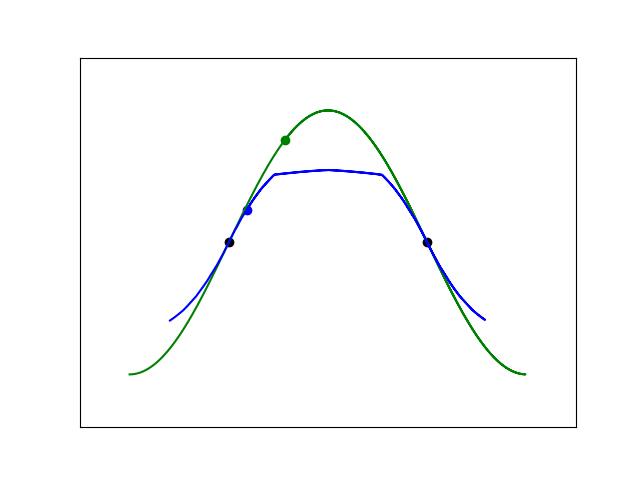

In [254]:
x = (t - 0.5) * 1.6
y = np.cos((t - 0.5)* 2 * np.pi) * 0.25
x = np.concatenate((x, list(reversed(x))), axis = 0)
y = np.concatenate((y, list(reversed(y))), axis = 0)

deltax = griddata(XY.reshape((-1, 2)), dfx.flatten(), np.column_stack((x,y)), method = 'linear')
deltay = griddata(XY.reshape((-1, 2)), dfy.flatten(), np.column_stack((x,y)), method = 'linear')

x_prime = x + s**2 * deltax / 2
y_prime = y + s**2 * deltay / 2

def update(i):
    plt.gca().clear()
    plt.xlim([-1, 1])
    plt.ylim([-0.35, 0.35])
    plt.scatter([x[i]], [y[i]], color = 'green')
    plt.plot(x[:i], y[:i], color = 'green')
    plt.scatter([x_prime[i]], [y_prime[i]], color = 'blue')
    plt.plot(x_prime[:i], y_prime[:i], color = 'blue')
    plt.scatter(*mu.T, color = 'black')

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
ani = FuncAnimation(plt.gcf(), update, range(len(x)), interval = 1)
plt.show()

<IPython.core.display.Javascript object>


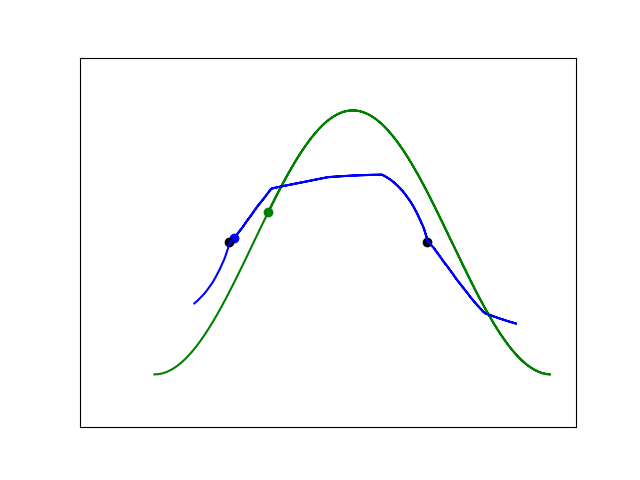

In [251]:
x = (t - 0.5) * 1.6 + 0.1
y = np.cos((t - 0.5)* 2 * np.pi) * 0.25
x = np.concatenate((x, list(reversed(x))), axis = 0)
y = np.concatenate((y, list(reversed(y))), axis = 0)

deltax = griddata(XY.reshape((-1, 2)), dfx.flatten(), np.column_stack((x,y)), method = 'linear')
deltay = griddata(XY.reshape((-1, 2)), dfy.flatten(), np.column_stack((x,y)), method = 'linear')

x_prime = x + s**2 * deltax / 2
y_prime = y + s**2 * deltay / 2

def update(i):
    plt.gca().clear()
    plt.xlim([-1, 1])
    plt.ylim([-0.35, 0.35])
    plt.scatter([x[i]], [y[i]], color = 'green')
    plt.plot(x[:i], y[:i], color = 'green')
    plt.scatter([x_prime[i]], [y_prime[i]], color = 'blue')
    plt.plot(x_prime[:i], y_prime[:i], color = 'blue')
    plt.scatter(*mu.T, color = 'black')

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
ani = FuncAnimation(plt.gcf(), update, range(len(x)), interval = 1)
plt.show()

# Discrete Potential

[[-0.4  0. ]
 [ 0.4  0. ]]


<IPython.core.display.Javascript object>


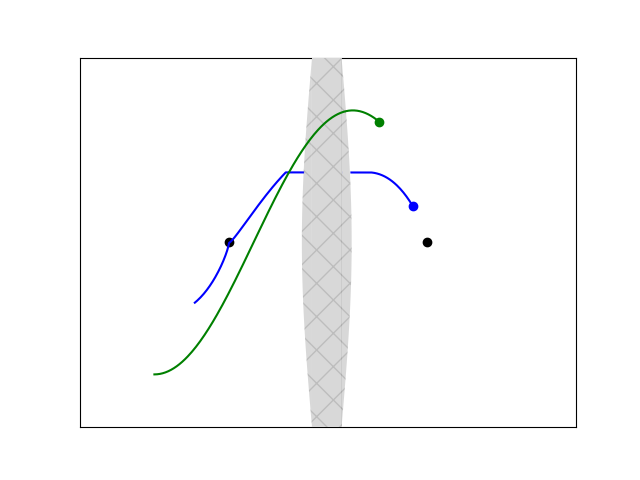

In [255]:
x = (t - 0.5) * 1.6 + 0.1
y = np.cos((t - 0.5)* 2 * np.pi) * 0.25
x = np.concatenate((x, list(reversed(x))), axis = 0)
y = np.concatenate((y, list(reversed(y))), axis = 0)

deltaxy = []
for i in range(len(x)):
    xy = np.array((x[i], y[i]))
    j = np.argmin(np.linalg.norm(xy - mu, axis = 1))
    deltaxy.append((xy - mu[j]) * np.exp(-(np.linalg.norm(xy-mu[j])/s)**2))
    #deltaxy.append(np.mean((xy - mu) * np.exp(-(np.linalg.norm(xy-mu, axis = 0)/s)**2), axis = 0))
deltaxy = np.array(deltaxy)

deltax = deltaxy[:,0]
deltay = deltaxy[:,1]

x_prime = x - deltax
y_prime = y - deltay
print(mu)
def update(i):
    plt.gca().clear()
    plt.xlim([-1, 1])
    plt.ylim([-0.35, 0.35])
    plt.scatter([x[i]], [y[i]], color = 'green', zorder = 6)
    plt.plot(x[:i], y[:i], color = 'green', zorder = 6)
    plt.scatter([x_prime[i]], [y_prime[i]], color = 'blue', zorder = 6)
    plt.plot(x_prime[:i], y_prime[:i], color = 'blue')
    plt.scatter(*mu.T, color = 'black')

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
    _y = np.arange(-0.35, 0.35, 0.001)
    _x = mu[0][0] * np.exp(-(mu[0][0]**2 + _y**2) / s**2) * s
    plt.gca().fill_between(_x, 0, _y, hatch = 'x', color = 'grey', alpha = 0.3, lw = 0, zorder = 5)
    plt.gca().fill_between(-_x-0.01, 0, _y, hatch = 'x', color = 'grey', alpha = 0.3, lw = 0, zorder = 5)
    plt.gca().fill_between([_x[0]+ 0.0, -_x[0]-0.01], -1, 1, hatch = 'x', color = 'grey', alpha = 0.3, lw = 0, zorder = 5)
    plt.gca().fill_between(_x, 0, _y, color = 'white', alpha = 1, lw = 0, zorder = 4)
    plt.gca().fill_between(-_x-0.01, 0, _y, color = 'white', alpha = 1, lw = 0, zorder = 4)
    plt.gca().fill_between([_x[0]+ 0.0, -_x[0]-0.01], -1, 1, color = 'white', alpha = 1, lw = 0, zorder = 4)
ani = FuncAnimation(plt.gcf(), update, range(len(x)), interval = 10)
plt.show()

# Input Dependent Velocity Scaling

<IPython.core.display.Javascript object>


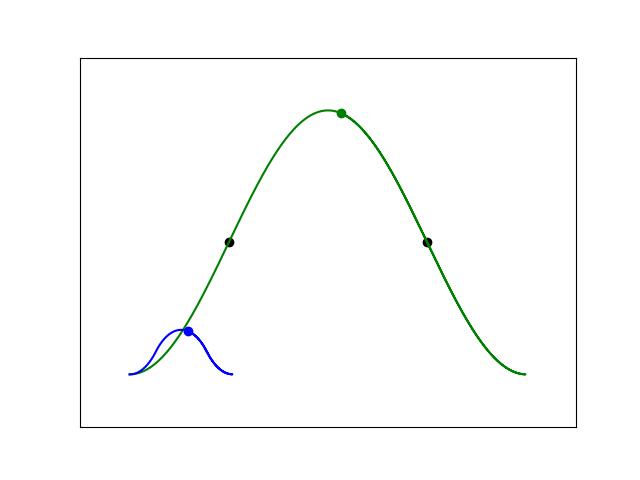

In [172]:
x_prime = x.copy()
y_prime = y.copy()

def speed(x, y):
    xy = np.array((x,y))
    return 1 - np.max(np.exp(-(np.linalg.norm(xy - mu, axis = 1)/s)**2))

_x, _y = x[0], y[0]
for i in range(len(x)):
    dx = x[i] - _x
    dy = y[i] - _y
    x_prime[max(i,0)] = x_prime[max(i-1,0)] + speed(_x, _y) * dx
    y_prime[max(i,0)] = y_prime[max(i-1,0)] + speed(_x, _y) * dy
    _x, _y = x[i], y[i]
    
def update(i):
    plt.gca().clear()
    plt.xlim([-1, 1])
    plt.ylim([-0.35, 0.35])
    plt.scatter([x[i]], [y[i]], color = 'green')
    plt.plot(x[:i], y[:i], color = 'green')
    plt.scatter([x_prime[i]], [y_prime[i]], color = 'blue')
    plt.plot(x_prime[:i], y_prime[:i], color = 'blue')
    plt.scatter(*mu.T, color = 'black')

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
ani = FuncAnimation(plt.gcf(), update, range(len(x)), interval = 10)
plt.show()
    

# Output Dependent Velocity Scaling

<IPython.core.display.Javascript object>


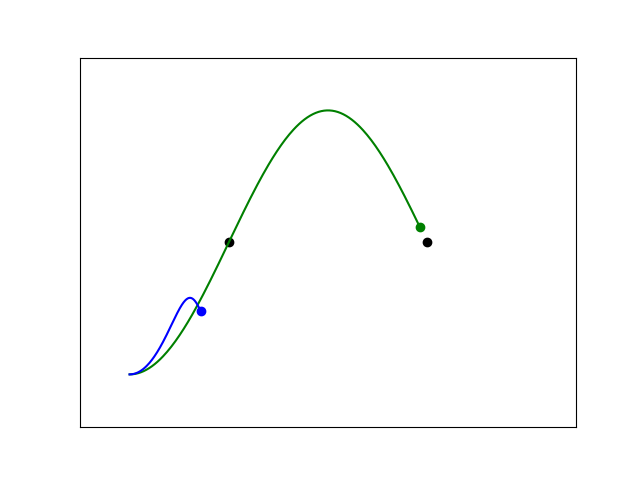

In [250]:
x_prime = x.copy()
y_prime = y.copy()

def speed(x, y):
    xy = np.array((x,y))
    return 1 - np.max(np.exp(-(np.linalg.norm(xy - mu, axis = 1)/s)**2))

_x, _y = x[0], y[0]
for i in range(len(x)):
    dx = x[i] - _x
    dy = y[i] - _y
    x_prime[max(i,0)] = x_prime[max(i-1,0)] + speed(x_prime[max(i-1,0)], y_prime[max(i-1,0)]) * dx
    y_prime[max(i,0)] = y_prime[max(i-1,0)] + speed(x_prime[max(i-1,0)], y_prime[max(i-1,0)]) * dy
    _x, _y = x[i], y[i]
    
def update(i):
    plt.gca().clear()
    plt.xlim([-1, 1])
    plt.ylim([-0.35, 0.35])
    plt.scatter([x[i]], [y[i]], color = 'green')
    plt.plot(x[:i], y[:i], color = 'green')
    plt.scatter([x_prime[i]], [y_prime[i]], color = 'blue')
    plt.plot(x_prime[:i], y_prime[:i], color = 'blue')
    plt.scatter(*mu.T, color = 'black')

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
ani = FuncAnimation(plt.gcf(), update, range(len(x)), interval = 10)
plt.show()
    

<IPython.core.display.Javascript object>


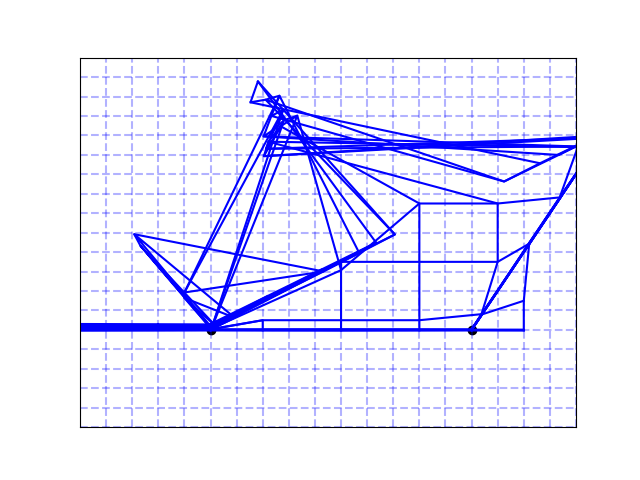

In [87]:
from scipy.optimize import LinearConstraint, NonlinearConstraint, minimize
import itertools
def displacement(xy, mu, s):
    i = np.argmin(np.linalg.norm(xy - mu, axis = 1))
    
    m = mu[i]
    mu = mu[np.arange(len(mu)) != i]
    
    Ns = mu - m
    Rs = np.linalg.norm(Ns, axis = 1)
    Ns = (Ns.T / Rs).T
    Rs /= 2
    
    Rs -= Ns @ (xy - m)
    
    disp = (m - xy) * np.exp(-(np.linalg.norm(m - xy)**2 / (s**2)))
    
    constraints = [LinearConstraint(Ns, -2 * Rs, 2 * Rs)]

    for i in range(1,len(xy)):
        for combo_i in itertools.combinations(range(len(Ns)), i+1):
            A = Ns[list(combo_i)]
            b = Rs[list(combo_i)]
            if np.linalg.matrix_rank(A.T) < i+1:
                continue
            p = np.linalg.lstsq(A, b, rcond = None)[0]
            
            d = np.linalg.norm(xy + p - m)
            n = (-np.sum(A, axis = 0)  + (m - xy)/(np.linalg.norm(m-xy))) /(i+2)
            
            gd = n * d * np.exp(-d**2 / s**2)
        
            if np.linalg.norm(disp - gd) > 2 * np.linalg.norm(p):
                constraints.append(
                    NonlinearConstraint(lambda x: np.linalg.norm(x - gd), 0, 2*np.linalg.norm(p)))
    
    res = minimize(lambda x: np.linalg.norm(x - disp)**2, disp.copy(), method = 'SLSQP',
                   jac = lambda x: 2 * (x - disp),
                  constraints = constraints)
    return res['x']

h = 0.01
s = 1
x = np.arange(-0.4,-0.2,h)
y = np.arange(-0.1,0.1,h)
X, Y = np.meshgrid(x, y)
XY = np.column_stack((X.flatten(), Y.flatten()))

theta = np.linspace(0, 2 * np.pi, 200)
#mu = np.array(((-0.4, 0), (0.4, 0)))
mu = 0.5 * np.array((np.cos(theta), np.sin(theta))).T
mu = np.array((np.arange(-0.5, 0.5, 0.01), np.zeros_like(np.arange(-0.5, 0.5, 0.01)))).T

n = np.arange(20)
mu_y = 1. * np.zeros_like(n)
mu_y[n % 2 == 0] += 0.2
mu_y[n % 2 != 0] -= 0.2

mu_x = 0.05*n - 0.5
mu = np.column_stack((mu_x, mu_y)) - 0.25
mu = np.concatenate((mu, np.column_stack((mu_x, mu_y)) + 0.25), axis = 0)

df = []
for xy in XY:
    disp = displacement(xy,mu,s)
    df.append(disp)
df = np.array(df)

XY_prime = XY + df
XY_prime = XY_prime.reshape((*X.shape, 2))
XY = XY.reshape(*X.shape,2)

plt.figure()
for i in range(0, len(XY_prime), 1):
    plt.plot(XY_prime[i,:,0], XY_prime[i,:,1], color = 'blue')
for i in range(0, len(XY_prime), 1):
    plt.plot(XY_prime[:,i,0], XY_prime[:,i,1], color = 'blue')
for i in range(0, len(XY_prime), 1):
    plt.plot(XY[i,:,0], XY[i,:,1], color = 'blue', linestyle = '--', alpha = 0.3)
for i in range(0, len(XY_prime), 1):
    plt.plot(XY[:,i,0], XY[:,i,1], color = 'blue', linestyle = '--', alpha = 0.3)
plt.scatter(*mu.T, color = 'black')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim([min(x), max(x)])
plt.ylim([min(y), max(y)])
plt.show()

In [83]:
h = 0.01
s = 0.2
x = np.arange(-0.4,-0.2,h)
y = np.arange(-0.1,0.1,h)
X, Y = np.meshgrid(x, y)
XY = np.column_stack((X.flatten(), Y.flatten()))

theta = np.linspace(0, 2 * np.pi, 200)
#mu = np.array(((-0.4, 0), (0.4, 0)))
mu = 0.5 * np.array((np.cos(theta), np.sin(theta))).T
mu = np.array((np.arange(-0.5, 0.5, 0.01), np.zeros_like(np.arange(-0.5, 0.5, 0.01)))).T

n = np.arange(20)
mu_y = 1. * np.zeros_like(n)
mu_y[n % 2 == 0] += 0.2
mu_y[n % 2 != 0] -= 0.2

mu_x = 0.05*n - 0.5
mu = np.column_stack((mu_x, mu_y)) - 0.25
mu = np.concatenate((mu, np.column_stack((mu_x, mu_y)) + 0.25), axis = 0)

df = []
hess = []
for xy in XY:
    disp = displacement(xy,mu,s)
    
    hess_xy = []
    for i in range(len(xy)):
        xy_h = xy.copy()
        xy_h[i] += 1e-8
        #hess_xy.append(np.linalg.norm((displacement(xy_h, mu, s) - disp) / 1e-8))
    hess.append(hess_xy)
        
    df.append(disp)
df = np.array(df)
#hess = np.array(hess).reshape((*X.shape, 2))

#plt.figure()
#plt.imshow(hess[:,:,0], origin = 1)
#plt.figure()
#plt.imshow(hess[:,:,1], origin = 1)
plt.quiver(*XY.T, *df.T)
plt.show()
